In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
ipc = pd.read_csv(r"C:\Users\cegom\Downloads\ipc0019.csv", parse_dates=[0])
ipc = (ipc[ipc.field == "PX_LAST"]
          .pivot(index = "date",columns = "ticker",values = "value")
          .rename(columns = lambda x: x.replace(" MF Equity","").replace("*","".strip()))
          .loc["2017-12-31":,:]
          )
ipc = ipc.dropna(axis = 1, thresh = round(len(ipc)*.95))

In [52]:
rets = ipc.pct_change().dropna(axis = 0)

In [58]:
Phi = rets.iloc[:, :-1].values
t = rets.iloc[:,[-1]]
N,M = Phi.shape

I = np.concatenate([np.identity(M)]*2, axis = 1)
I = np.concatenate([I]*2, axis = 0)

In [60]:
P = np.ones((N, M))
P = np.c_[P, Phi]

In [70]:
W = np.linalg.inv((P.T @ P) * I) @ P.T @ t
W["security"] = np.concatenate([rets.columns[:-1]]*2)
W["params"] = ["alpha"] * M + ["beta"]*M
B = W.pivot_table(index = "security", columns = "params", values = "WALMEX")

In [71]:
from ipywidgets import interact

@interact(security = rets.columns[:-1])

def plot_capm(security):
    rets.plot.scatter(x = security, y = "WALMEX", alpha = 0.6)
    sec = rets[security]
    x = np.linspace(sec.min(), sec.max(), 100)
    alpha, beta = B.loc[security]
    plt.plot(x, alpha + beta * x, c = "tab:orange", linewidth = 4)

interactive(children=(Dropdown(description='security', options=('AC', 'ALFAA', 'ALPEKA', 'ALSEA', 'AMXL', 'ASU…

### Construcción de Portafolio

In [120]:
rend = rets.sample(5, axis = 1).loc["2018-01-03":"2018-12-31",:]

In [121]:
weights = np.random.random(5)
weights = weights / sum(weights)

In [145]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights).sum() * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

In [164]:
weights_sim = np.random.randn(5000, 5)
weights_sim = weights_sim/ weights_sim.sum(axis = 1, keepdims = True)

rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r = rend)
vol_sim  = np.apply_along_axis(port_vol, 1, weights_sim, r = rend)

### Optimización de portafolio

In [165]:
from scipy.optimize import minimize

In [186]:
N, M = rend.shape
w0 = np.random.randn(M)


def sum_weights(weights):
    return weights.sum() - 1

def rend_esperado(w, E):
    return port_rend(w, rend) - E

e0 = 0.01

constraints = [
    {"type": "eq", "fun": sum_weights},
    {"type": "eq", "fun": lambda w: rend_esperado(w,e0)}
]

port0  = minimize(port_vol, w0, constraints = constraints, args = rend)
port0

     fun: 0.16005262501667566
     jac: array([0.15503004, 0.14964319, 0.15084998, 0.17877042, 0.16044132])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.17201648, 0.13529778, 0.35119308, 0.29305921, 0.04843345])

In [187]:
wp0 = port0.x

### Tarea

In [207]:
N, M = rend.shape
w0 = np.random.randn(M)

def comp_menos_riesgo(w, rend):
    #el activo más riesgoso no puede rebasar el 8% de la composición del portafolio
    act_max_vol = (rend.cov() * np.identity(len(rend.cov()))).max().argmax()
    return -w[act_max_vol] + 0.08

e0 = 0.01

constraints = [
    {"type": "eq", "fun": sum_weights},
    {"type": "eq", "fun": lambda w: rend_esperado(w,e0)},
    {"type": "ineq", "fun": lambda w: comp_menos_riesgo(w,rend)}
]

port1  = minimize(port_vol, w0, constraints = constraints, args = rend)
port1

     fun: 0.1613133380675014
     jac: array([0.16154994, 0.11311235, 0.15943012, 0.17654383, 0.16489253])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.20288657, 0.08      , 0.37426353, 0.28200897, 0.06084093])

In [203]:
wp1 = port1.x

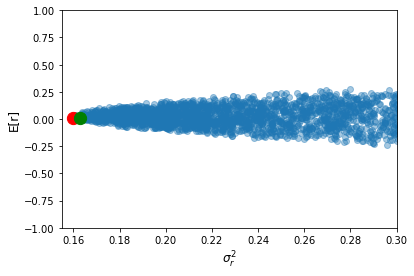

In [226]:
plt.scatter(vol_sim, rend_sim, alpha = 0.4)
plt.scatter(port_vol(wp0, rend), port_rend(wp0, rend), c = "red", s = 150)
plt.scatter(port_vol(wp1, rend), port_rend(wp1, rend), c = "green", s = 150)
plt.xlabel(r"$\sigma^2_r$", fontsize = 12)
plt.ylabel("E[r]", fontsize = 12)
plt.xlim(0.155,.3)
plt.ylim(-1,1)
plt.show()